 ### Dictionary Learning for bandwidth extension of room impulse responses 

The room impulse response (RIR) describes the acoustic transfer function between a sound source and a receiver inside a room. Many acoustic parameters of a room, like the reverberation time, are contained in its RIRs. In addition, RIRs are required to recreate virtual acoustic environments, as well as in sound field control applications, room acoustic desing, etc. 

Oftentimes, we only have access to the low frequency content of the RIRs, either because we are estimating the RIR from sparse measured data, or because numerical simulations at high frequencies become computationally very expensive. 

The goal of bandwidth extension is to infer the high-frequency content of RIRs from their low-frequency content. In this notebook we will see how we can do that using Dictionary Learning (DL).

By Samuel A. Verburg, saveri@dtu.dk

In [1]:
import numpy as np
import scipy
from scipy import signal
import matplotlib.pyplot as plt
import sklearn
from sklearn.decomposition import DictionaryLearning

We start by downloading the MeshRIR dataset https://www.sh01.org/MeshRIR/ from zenodo https://zenodo.org/records/10852693. Download only the data 'S1-M3969_npy.zip' and the file 'src.zip'. Create a directory called './data' and unzip the files there. To make all this automatically, uncomment and run the next cell. It requires that you have `requests` installed in your environment. 

Important: If you use git, remember to add the './data' folder to .gitignore.

In [2]:
# import os, requests, zipfile

# def download_url(url, save_path, chunk_size=128):
#     r = requests.get(url, stream=True)
#     with open(save_path, 'wb') as fd:
#         for chunk in r.iter_content(chunk_size=chunk_size):
#             fd.write(chunk)

# # Make directory
# os.mkdir("data")

# # Download and unzip data files (approx 1 GB)
# save_path = "./data/S1-M3969_npy.zip"
# url = "https://zenodo.org/records/10852693/files/S1-M3969_npy.zip?download=1"
# download_url(url, save_path)
# with zipfile.ZipFile(save_path, 'r') as zObject: 
# 	zObject.extractall(path="./data") 
# os.remove(save_path) 

# # Download and unzip aux files (approx 500 kB)
# save_path = "./data/src.zip"
# url = "https://zenodo.org/records/10852693/files/src.zip?download=1"
# download_url(url, save_path)
# with zipfile.ZipFile(save_path, 'r') as zObject: 
#     zObject.extractall(path="./data") 
# os.remove(save_path)

#### Load and pre-process RIR data
We start by loading the RIR data and downsampling it to make it easier to work with. We also compute the one-side spectrum of the RIRs.  

In [ ]:
from pathlib import Path
from data.src.irutilities import loadIR
sessionName = "S1-M3969_npy"
sessionPath = Path('./data').joinpath(sessionName)

# Load files
posMic, posSrc, ir = loadIR(sessionPath)
ir = np.squeeze(ir)

# Downsample
downsamp_factor = 50
ir = signal.decimate(ir, downsamp_factor, n=None, ftype='fir', axis=-1, zero_phase=True)

# Sampling rate
samplerate = int(48000/downsamp_factor)

# Frequency response (one side) 
N = ir.shape[1]
t = np.arange(N) / samplerate
fr = np.fft.fft(ir, axis=-1)
f = np.fft.fftfreq(N, d=1/samplerate)
fr = fr[:,0:int(N/2)]
f = f[0:int(N/2)]

ModuleNotFoundError: No module named 'data'

We apply a low pass filter to the data, so that we can test the DL estimation of the full-bandwidth RIR from its low pass version. 

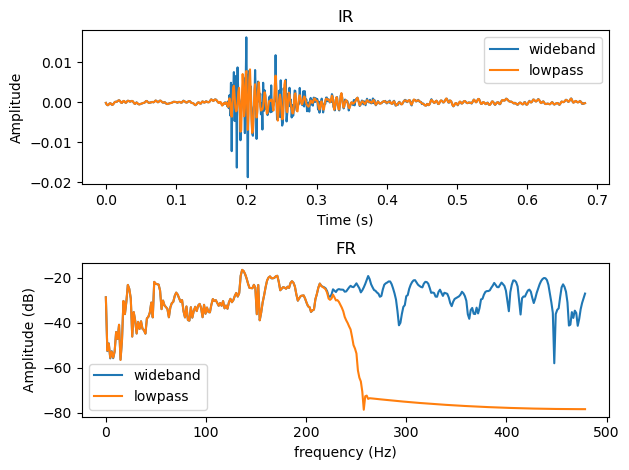

In [ ]:
# Lowpass filter
cutoff = f[-1]/2 # filter out half of the spectrum
numtaps = 64
h = signal.firwin(numtaps=numtaps, cutoff=cutoff, fs=samplerate)
ir_lp = signal.filtfilt(h, 1, ir, axis=-1)
fr_lp = np.fft.fft(ir_lp, axis=-1)
fr_lp = fr_lp[:,0:int(N/2)]

# Plot
fig, [ax1, ax2] = plt.subplots(2, 1)
ax1.plot(t, ir[0,:], label='wideband')
ax1.plot(t, ir_lp[0,:], label='lowpass')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Amplitude')
ax1.set_title('IR')
ax1.legend()
ax2.plot(f, 20*np.log10(np.abs(fr[0,:])), label='wideband')
ax2.plot(f, 20*np.log10(np.abs(fr_lp[0,:])), label='lowpass')
ax2.set_xlabel('frequency (Hz)')
ax2.set_ylabel('Amplitude (dB)')
ax2.set_title('FR')
ax2.legend()
fig.tight_layout()
plt.show()

Later on it will be convenient to perfrom the lowpass filtering oparation as a matrix-vector product. For that we compute the filtering matrix $\mathbf{H}$ and compare the results with the filter applied using `scipy.signal.filtfilt`. We see that the results are almost identical. 

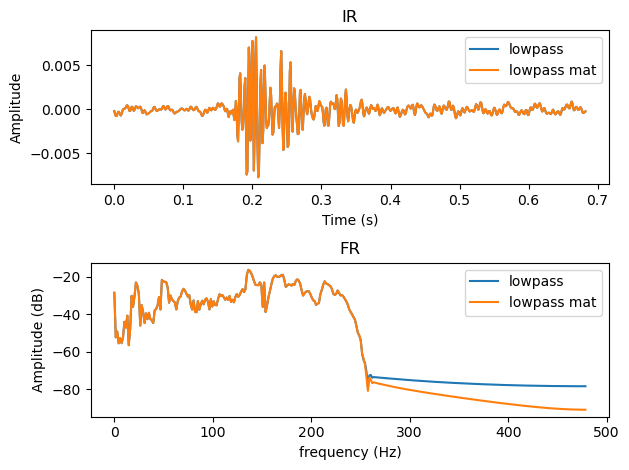

In [ ]:
# Low pass filter as a matrix-vector product'
h = h.reshape(-1,1)
r = np.pad(h, ((0,N-1),(0,0)))
c = np.zeros((N,1))
c[0] = h[0]
H = scipy.linalg.toeplitz(c, r)
H = H @ H.T
ir_lp_mat = ir @ H
fr_lp_mat = np.fft.fft(ir_lp_mat, axis=-1)
fr_lp_mat = fr_lp_mat[:, 0:int(N/2)]

# Plot
fig, [ax1, ax2] = plt.subplots(2, 1)
ax1.plot(t, ir_lp[0,:], label='lowpass')
ax1.plot(t, ir_lp_mat[0,:], label='lowpass mat')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Amplitude')
ax1.set_title('IR')
ax1.legend()
ax2.plot(f, 20*np.log10(np.abs(fr_lp[0,:])), label='lowpass')
ax2.plot(f, 20*np.log10(np.abs(fr_lp_mat[0,:])), label='lowpass mat')
ax2.set_xlabel('frequency (Hz)')
ax2.set_ylabel('Amplitude (dB)')
ax2.set_title('FR')
ax2.legend()
fig.tight_layout()
plt.show()

 #### Dictionary Learning

Dictionary Learning (DL) aims at finding a dictionary that can sparsely represent the type of signal that we want to reconstruct, in our case RIRs. 
A 'dictionary' is a set of vectors, often called 'atoms', whose linear combination is used to represent the signal. Such linear combination can be written as

$$ \mathbf{y} = \mathbf{Dx}, $$

where $ \mathbf{y} \in \mathbb{R}^{N}$ is a RIR, $ \mathbf{D} \in \mathbb{R}^{N \times K} $ is the dictionary, and $ \mathbf{x} \in \mathbb{R}^{K} $ is the vector of coefficients that tells us which of the dictionary atoms we should combine in order to get $ \mathbf{y} $. $K$ is the number of atoms in the dictionary and $N$ is the signal dimension, in our case the length of each RIR. If $N<K$ and $\mathbf{D}$ is full rank, $\mathbf{D}$ is an *overcomplete* representation, and there are infinitely many solutions to the system of equations. Sparse coding aims at finding the sparsest one, i.e., finding

$$ \arg \min_{\mathbf{x}} \| \mathbf{x} \|_0  \quad \text{subject to} \quad \|\mathbf{y-Dx}\|^2_2  \leq \epsilon,$$

or alternatively, 

$$ \arg \min_{\mathbf{x}} \| \mathbf{y-Dx} \|^2_2  + \alpha_0  \| \mathbf{x} \|_0, $$

where $\| \cdot \|_0 $ stands for the $\ell_0$ pseudo-norm, which counts the number of non-zero entries of a vector. Finding the sparsest $\mathbf{x}$ is a combinatorial problem, and therefore it cannot be solved exactly in a reasonable amount of time unless $K$ and $N$ are very small. It is common to either approximate the solution using greedy algorithms, or to relax the problem so it becomes convex leading to the lasso regression, 

$$ \arg \min_{\mathbf{x}} \| \mathbf{y-Dx} \|^2_2  + \alpha_1  \| \mathbf{x} \|_1. $$

Sparse coding has become commonplace in signal and image processing with applications in compression, denoising, feature extraction, etc. See for example Elad's 2010 book 'Sparse and Redundant Representations' https://link.springer.com/book/10.1007/978-1-4419-7011-4  or the JASA compressive sensing special issue [Gerstoft 2018] https://doi.org/10.1121/1.5043089 

A key concept here is that a dictionary that can represent a signal *sparsely* effectively encodes the signal structure, which is crucial for reconstructing it from partial or corrupted data. However, we do not know what that dictionary looks like in principle. The idea of DL is to learn $\mathbf{D}$ from training data. (As a side note, there are signals for which we do know sparsifying representations. The simplest example being a pure tone, which can be repesented by just one coefficient using a DFT matrix as the 'dictionary'). 
The DL problem can be writen as finding
$$ \arg \min_{\mathbf{X,D}} \frac{1}{2} \| \mathbf{Y-DX} \|^2_\text{fro} + \alpha \|\mathbf{X}\|_{1,1} \quad \text{subject to} \quad \|\mathbf{D}_k \|_2 \leq 1 \quad \forall \quad 0 \leq k \leq K $$
where $\mathbf{Y}\in \mathbb{R}^{N \times M}$ is the traning data (each column of $\mathbf{Y}$ is a RIR in the traning set of size $M$), $\| \cdot \|_\text{fro}$ is the Frobenious norm, and $\|\cdot\|_{1,1}$ is the sum of the absolute value of all the entries in a matrix. Notice that we have relaxed the $\ell_0$ to the $\ell_1$ norm. The optimization problem is solved by alternating:
1. an update of the sparse matrix $\mathbf{X}$, considering a fixed $\mathbf{D}$ (this step can be seen as solving $M$ lasso regression problems) 
2. an update of the dictionary while fixing $\mathbf{X}$. 

After a number of iterations we obtain the learned dictionary $\mathbf{D}$ and the sparse matrix of coefficients for the traning data $\mathbf{X}$.

We start be splitting the dataset into traning and validation. The dataset is quite large so, to speed up things, we take just 20% of the RIRs for traning and 20% for validation.
 

In [ ]:
# Split data into traning and validation
ir_train, ir_test = sklearn.model_selection.train_test_split(ir, test_size=0.8, random_state=42)
ir_unused, ir_test = sklearn.model_selection.train_test_split(ir_test, test_size=0.25, random_state=42)

print('Numer of RIRs in the training set:', str(ir_train.shape[0]))
print('Numer of RIRs in the validation set:', str(ir_test.shape[0]))

Numer of RIRs in the training set: 793
Numer of RIRs in the validation set: 794


We use sklearn `DictionaryLearning` class for learning the dictionary. It is higly configurable, with different algorithms to choose from and hyperparameters to tune. Let's see how it works with the default ones. 

As we downsampled the original dataset and we only take 20% of all the RIRs for training, this should run rather fast (approx. 1 min on my laptop, 5 sec in my workstation). 

In [ ]:
# Learn dictionary
n_components = N*2 # number of atoms in the dictionary
dict_learner = DictionaryLearning(n_components=n_components, alpha=1, n_jobs=-1, verbose=True)
x_train = dict_learner.fit(ir_train).transform(ir_train)
D = dict_learner.components_

[dict_learning] .

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 36 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  36 | elapsed:    1.8s remaining:   31.4s
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:    2.3s finished


1312 unused atoms resampled.
.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 36 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  36 | elapsed:    1.1s remaining:   18.9s
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:    1.3s finished


1312 unused atoms resampled.



We can test if the learned dictionary can represent the validation data. We use sklearn `SparseCoder` class to solve the sparse coding optimization problem. Again, there are different algorithms and hyperparameters to play with but we go with the default ones. 

In [ ]:
# Estimate IRs in validation set
sparse_coder = sklearn.decomposition.SparseCoder(D)
x_test = sparse_coder.transform(ir_test)
Dx_test = x_test @ D

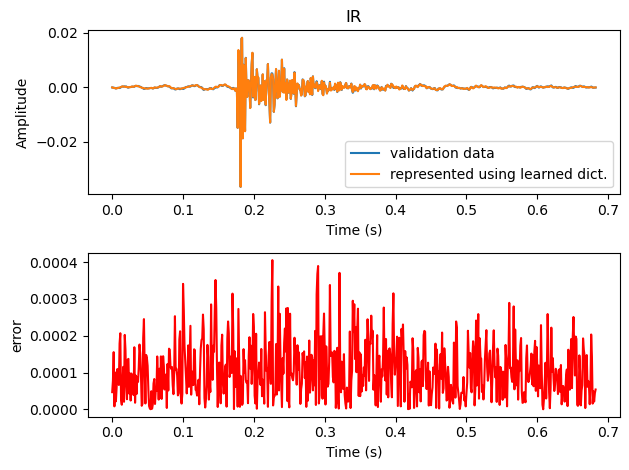

In [ ]:
# Plot one of the validation RIRs
i_plt = 0
fig, [ax1, ax2] = plt.subplots(2, 1)
ax1.plot(t, ir_test[i_plt,:], label='validation data')
ax1.plot(t, Dx_test[i_plt,:], label='represented using learned dict.')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Amplitude')
ax1.set_title('IR')
ax1.legend()
ax2.plot(t, np.abs(ir_test[i_plt,:] - Dx_test[i_plt,:]), 'r')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('error')
fig.tight_layout()
plt.show()

#### Bandwidth extension

Once the dictionary is learned, we can proceed to the problem of reconstructing the high-frequency content of the RIRs from their lowpass version,
$$
\mathbf{y}_{lp} = \mathbf{Hy},
$$
where $\mathbf{H} \in \mathbb{R}^{N\times N}$ performs the low pass filtering operation. The sparse coding problem is then
$$ \min_{\mathbf{x}} \| \mathbf{y}_{lp}-\mathbf{HDx} \|^2_2  + \alpha_1  \| \mathbf{x} \|_1, $$
where we use the dictionary $\mathbf{D}$ that we learned before from the full-bandwidth training RIRs. 
By solving the sparse coding problem we get an estimate of the sparse coefficients $\tilde{\mathbf{x}}$. The full-bandwidth RIR is then reconstructed by computing
$$
\tilde{\mathbf{y}} = \mathbf{D}\tilde{\mathbf{x}}.
$$


In [ ]:
# Solve lowpass version of the sparse coding problem
ir_test_lp = ir_test @ H
D_lp = D @ H
sparse_coder_lp = sklearn.decomposition.SparseCoder(D_lp)
x_test_lp = sparse_coder_lp.transform(ir_test_lp)
Dx_test_lp = x_test_lp @ D

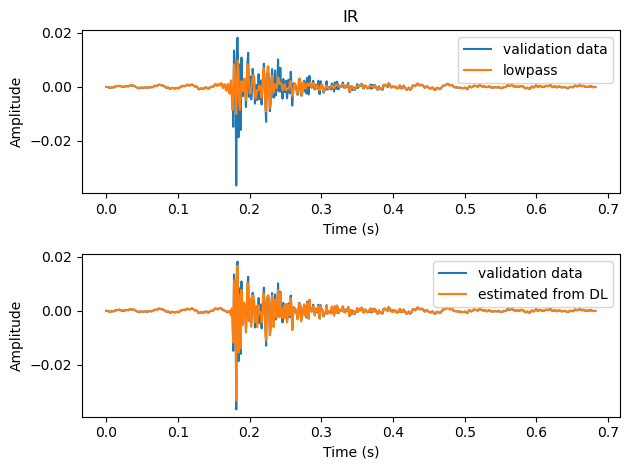

In [ ]:
#  Plot RIRs
i_plt = 0
fig, [ax1, ax2] = plt.subplots(2, 1)
ax1.plot(t, ir_test[i_plt,:], label='validation data')
ax1.plot(t, ir_test_lp[i_plt,:], label='lowpass')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Amplitude')
ax1.set_title('IR')
ax1.legend()
ax2.plot(t, ir_test[i_plt,:], label='validation data')
ax2.plot(t, Dx_test_lp[i_plt,:], label='estimated from DL')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Amplitude')
ax2.legend()
fig.tight_layout()
plt.show()

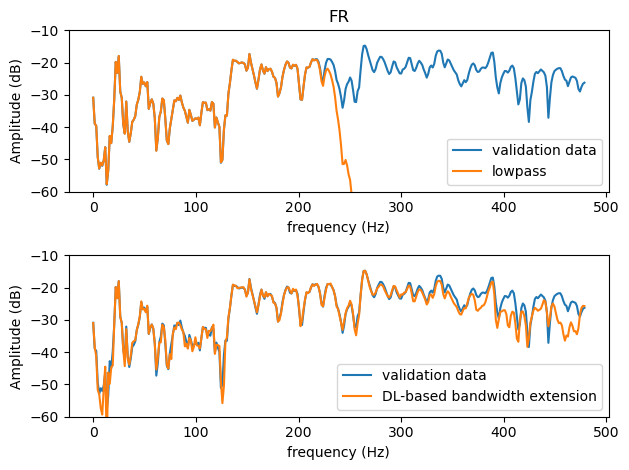

In [ ]:
# Compute frequency responses
fr_test = np.fft.fft(ir_test, axis=-1)
fr_test = fr_test[:,0:int(N/2)]

fr_test_lp = np.fft.fft(ir_test_lp, axis=-1)
fr_test_lp = fr_test_lp[:,0:int(N/2)]

fr_ext = np.fft.fft(Dx_test_lp, axis=-1)
fr_ext = fr_ext[:,0:int(N/2)]

# Plot frequency responses
ymin = -60
ymax = -10

i_plt = 0
fig, [ax1, ax2] = plt.subplots(2, 1)
ax1.plot(f, 20*np.log10(np.abs(fr_test[i_plt,:])), label='validation data')
ax1.plot(f, 20*np.log10(np.abs(fr_test_lp[i_plt,:])), label='lowpass')
ax1.set_xlabel('frequency (Hz)')
ax1.set_ylabel('Amplitude (dB)')
ax1.set_title('FR')
ax1.set_ylim([ymin, ymax])
ax1.legend()

ax2.plot(f, 20*np.log10(np.abs(fr_test[i_plt,:])), label='validation data')
ax2.plot(f, 20*np.log10(np.abs(fr_ext[i_plt,:])), label='DL-based bandwidth extension')
ax2.set_xlabel('frequency (Hz)')
ax2.set_ylabel('Amplitude (dB)')
ax2.legend()
ax2.set_ylim([ymin, ymax])
fig.tight_layout()
plt.show()

It looks quite good. Let's see how the errors compare.

In [ ]:
def mae(a, b):
    return np.mean(np.abs(a - b))

Dx_train = x_train @ D
mae_train = mae(Dx_train, ir_train)
mae_test = mae(Dx_test, ir_test)
mae_test_lp = mae(ir_test_lp, ir_test)
mae_test_ext = mae(Dx_test_lp, ir_test)

print('Mean absolute error for the training set:', str(np.round(mae_train*1e5, 3))+'e-5')
print('Mean absolute error for the validation set:', str(np.round(mae_test*1e5, 3))+'e-5')
print('Mean absolute error for the validation set lowpass filtered:', str(np.round(mae_test_lp*1e5, 3))+'e-5')
print('Mean absolute error for the validation set bandwidth extended:', str(np.round(mae_test_ext*1e5, 3))+'e-5')


Mean absolute error for the training set: 3.33e-5
Mean absolute error for the validation set: 10.527e-5
Mean absolute error for the validation set lowpass filtered: 62.775e-5
Mean absolute error for the validation set bandwidth extended: 26.989e-5


### How does the dictionary look like?

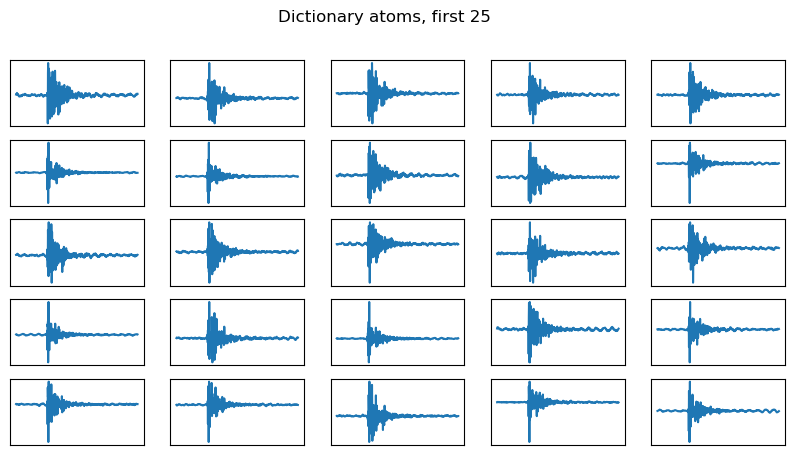

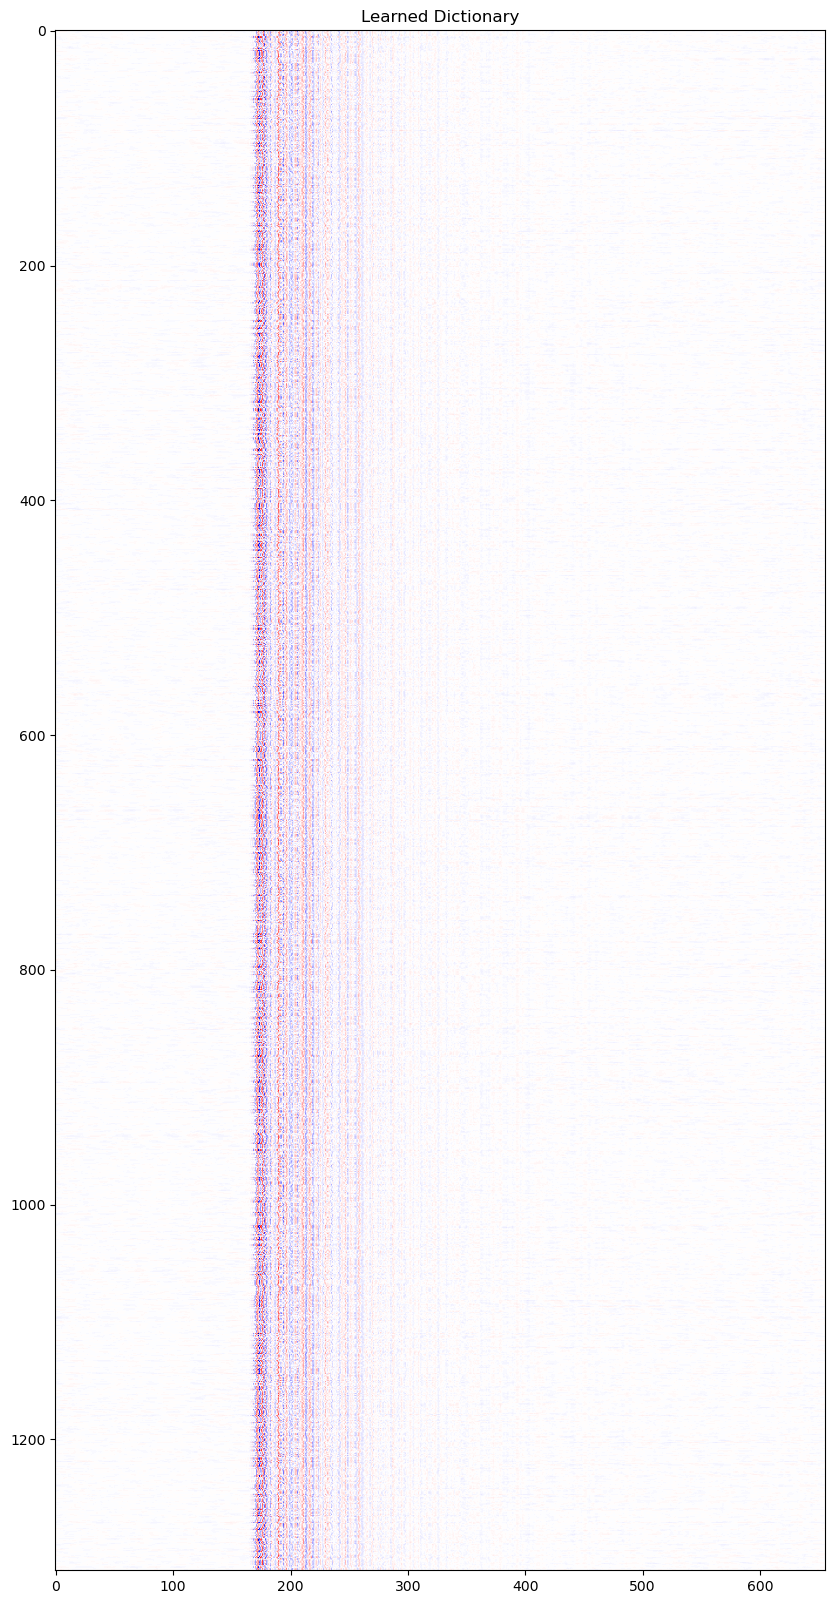

In [ ]:
plt.figure(figsize=(10,5))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.plot(t, D[i,:])
    plt.xticks(())
    plt.yticks(())
plt.suptitle("Dictionary atoms, first 25")

D_max = np.max(np.abs(D))
fig, ax = plt.subplots(figsize=(10,20))
ax.imshow(D, vmin = -D_max, vmax = D_max, cmap='seismic')
ax.set_title('Learned Dictionary')
plt.show()

###  How do the coefficients look like?

Number of non-zero elements in x_test_lp on average: 65.0


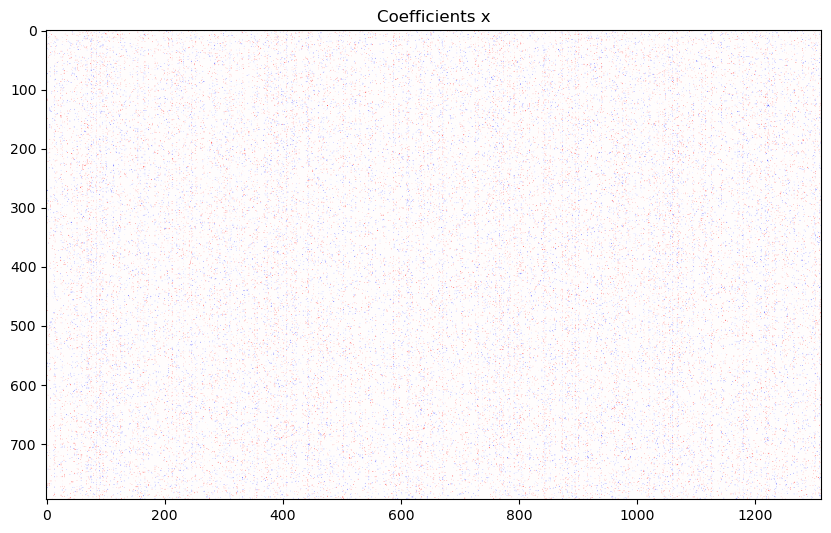

In [ ]:
print("Number of non-zero elements in x_test_lp on average:",
       str(np.mean(np.sum(x_test_lp != 0, axis=1))))

x_max = np.max(np.abs(x_test_lp))
fig, ax = plt.subplots(figsize=(10,20))
ax.imshow(x_test_lp, vmin = -x_max, vmax = x_max, cmap='seismic')
ax.set_title('Coefficients x')
plt.show()

### References

[Koyama 2021] Koyama, S., Nishida, T., Kimura, K., Abe, T., Ueno, N., & Brunnström, J. (2021, October). MeshRIR: A dataset of room impulse responses on meshed grid points for evaluating sound field analysis and synthesis methods. In 2021 IEEE workshop on applications of signal processing to audio and acoustics (WASPAA) (pp. 1-5). IEEE. https://zenodo.org/records/10852693

[Elad 2010] Elad, M. (2010). Sparse and redundant representations: from theory to applications in signal and image processing. Springer Science & Business Media. https://link.springer.com/book/10.1007/978-1-4419-7011-4 

[Gerstoft 2018] Gerstoft, P., Mecklenbräuker, C. F., Seong, W., & Bianco, M. (2018). Introduction to compressive sensing in acoustics. The Journal of the Acoustical Society of America, 143(6), 3731-3736. https://doi.org/10.1121/1.5043089 

[Bianco 2017] Bianco, M., & Gerstoft, P. (2017). Dictionary learning of sound speed profiles. The Journal of the Acoustical Society of America, 141(3), 1749-1758. 
https://doi.org/10.1121/1.4977926

[Hahmann 2021] Hahmann, M., Verburg, S. A., & Fernandez-Grande, E. (2021). Spatial reconstruction of sound fields using local and data-driven functions. The Journal of the Acoustical Society of America, 150(6), 4417-4428. 
https://doi.org/10.1121/10.0008975